In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src'
os.sys.path.insert(1, srcdir)

import numpy as np

import time
import pybullet as p
import pybullet_data
import pinocchio as se3
import matplotlib
import tsid
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import commands

import matplotlib.pyplot as plt
from pinbullet_wrapper import PinBulletWrapper
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import zero

from dotmap import DotMap
import pickle

In [2]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
BMODE = p.DIRECT
LOGGING = False
LOCAL = True

N_SIMULATION = 5000

DELAY = 30
NS3 = True
SCENARIO = 'building'
DELAY_START = 0

IMPACT_START = 1350
IMPACT_DURATION = 200
IMPACT_FORCE = [100, 0, 0]

In [4]:
# compute delayed indices
DELAYED_IDX = []

if NS3:
    ns3path = parentdir + '/data/ns3/rtt/'
    td = np.load(ns3path + 'td_'+ SCENARIO +'.npy')
    td = np.tile(td, int((N_SIMULATION + 1.0)/len(td)) + 1)
    td = td[:N_SIMULATION]
    time_received = np.array([i + td[i] for i in range(N_SIMULATION)])
    
    for i in range(N_SIMULATION):
        # find the latest command arrived before the current time
        idx_arrived = np.nonzero(time_received <= i)[0]
        if idx_arrived.size > 0:
            delayed_idx = idx_arrived.max()
        else:
            delayed_idx = 0
        DELAYED_IDX.append(delayed_idx)
    
    
else:
    for i in range(N_SIMULATION):
        if i>=DELAY_START:
            delayed_idx = np.maximum(i-DELAY, DELAY_START)
        else:
            delayed_idx = i
        DELAYED_IDX.append(delayed_idx)

In [5]:
LINE_WIDTH = 60
print "".center(LINE_WIDTH,'#')
print " Test Task Space Inverse Dynamics ".center(LINE_WIDTH, '#')
print "".center(LINE_WIDTH,'#'), '\n'

lxp = 0.14                          # foot length in positive x direction
lxn = 0.077                         # foot length in negative x direction
lyp = 0.069                         # foot length in positive y direction
lyn = 0.069                         # foot length in negative y direction
lz = 0.105                          # foot sole height with respect to ankle joint
mu = 1.0                            # friction coefficient
fMin = 5.0                          # minimum normal force
fMax = 1000.0                       # maximum normal force
rf_frame_name = "RAnkleRoll"        # right foot frame name
lf_frame_name = "LAnkleRoll"        # left foot frame name
contactNormal = np.matrix([0., 0., 1.]).T   # direction of the normal to the contact surface

w_com = 1.0                     # weight of center of mass task
w_posture = 1e-3                # weight of joint posture task
w_forceRef = 1e-5               # weight of force regularization task

kp_contact = 10.0               # proportional gain of contact constraint
kp_com = 10.0                   # proportional gain of center of mass task
kp_posture = 30.0               # proportional gain of joint posture task

sigma_q = 1e-2
sigma_v = 1e-2

############################################################
############# Test Task Space Inverse Dynamics #############
############################################################ 



In [6]:
path = parentdir + '/models/romeo'
robot_urdf = path + '/urdf/romeo.urdf'
plane_urdf = parentdir + '/models/plane.urdf'
vector = se3.StdVec_StdString()
vector.extend(item for item in path)
robot = tsid.RobotWrapper(robot_urdf, vector, se3.JointModelFreeFlyer(), False)
pinocchio_robot = se3.buildModelFromUrdf(robot_urdf, se3.JointModelFreeFlyer())

In [7]:
physicsClient = p.connect(BMODE)
dt = 1e-3
p.setTimeStep(dt)
p.setGravity(0,0,-9.81)
robot_id = p.loadURDF(robot_urdf,[0,0,0])
plane_id = p.loadURDF(plane_urdf,[0,0,-0.88], useFixedBase=True)

In [8]:
joint_names = [n for n in robot.model().names]
del joint_names[0]
del joint_names[0]
endeff_names = ["l_sole", "r_sole"]
pbwrapper = PinBulletWrapper(robot_id, pinocchio_robot, joint_names, endeff_names)

In [9]:
p.changeDynamics(plane_id, -1, restitution=0.99,
                 lateralFriction=1.0, spinningFriction=1.0, rollingFriction=1.0,
                 contactStiffness=1e6, contactDamping=2e3)
p.resetJointState(robot_id, 20, np.pi/3)
p.resetJointState(robot_id, 27, np.pi/3)

In [10]:
q, v = pbwrapper.get_state()
assert robot.model().existFrame(rf_frame_name)
assert robot.model().existFrame(lf_frame_name)

In [11]:
t = 0.0                         # time
invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()
contact_Point = np.matrix(np.ones((3,4)) * lz)
contact_Point[0, :] = [-lxn, -lxn, lxp, lxp]
contact_Point[1, :] = [-lyn, lyp, -lyn, lyp]

contactRF =tsid.Contact6d("contact_rfoot", robot, rf_frame_name, contact_Point, contactNormal, mu, fMin, fMax, w_forceRef)
contactRF.setKp(kp_contact * matlib.ones(6).T)
contactRF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
H_rf_ref = robot.position(data, robot.model().getJointId(rf_frame_name))
contactRF.setReference(H_rf_ref)
invdyn.addRigidContact(contactRF)

contactLF =tsid.Contact6d("contact_lfoot", robot, lf_frame_name, contact_Point, contactNormal, mu, fMin, fMax, w_forceRef)
contactLF.setKp(kp_contact * matlib.ones(6).T)
contactLF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
H_lf_ref = robot.position(data, robot.model().getJointId(lf_frame_name))
contactLF.setReference(H_lf_ref)
invdyn.addRigidContact(contactLF)

True

In [12]:
comTask = tsid.TaskComEquality("task-com", robot)
comTask.setKp(kp_com * matlib.ones(3).T)
comTask.setKd(2.0 * np.sqrt(kp_com) * matlib.ones(3).T)
invdyn.addMotionTask(comTask, w_com, 1, 0.0)

postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * matlib.ones(robot.nv-6).T)
postureTask.setKd(2.0 * np.sqrt(kp_posture) * matlib.ones(robot.nv-6).T)
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

com_ref = robot.com(data)
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref)

q_ref = q[7:]
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q_ref)

solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

In [13]:
for i in range(2000):
    
    sampleCom = trajCom.computeNext()
    comTask.setReference(sampleCom)
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)
    HQPData = invdyn.computeProblemData(t, q, v)
    
    sol = solver.solve(HQPData)
    tau = invdyn.getActuatorForces(sol)
    dv = invdyn.getAccelerations(sol)                 
    if(sol.status!=0):
        print "QP problem could not be solved! Error code:", sol.status
        break
              
    # bullet
    pbwrapper.send_joint_command(tau)    
    p.stepSimulation()
    q, v = pbwrapper.get_state()
    t += dt
    
com_ref = robot.com(invdyn.data())
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref)

In [14]:
LOG = []
SOL = []

for i in range(0, N_SIMULATION):
    
    data = DotMap()
    LOG.append(data)
    sampleCom = trajCom.computeNext()
    comTask.setReference(sampleCom)
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)
    
    noise_q = sigma_q * np.matrix(np.random.randn(q.shape[0])).T
    noise_q[:7] = 0

    noise_v = sigma_v * np.matrix(np.random.randn(v.shape[0])).T
    noise_v[:6] = 0
    
    HQPData = invdyn.computeProblemData(t, q+noise_q, v+noise_v)
    
    data.q = q + noise_q
    data.v = v + noise_v
    data.noise_q = noise_q
    data.noise_v = noise_v
    
    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print "QP problem could not be solved! Error code:", sol.status
        break
    SOL.append(sol)
    tau = invdyn.getActuatorForces(sol)
    data.tau_remote = tau
    
    delayed_idx = DELAYED_IDX[i]
    data.delay = i - delayed_idx
    delayed_data = LOG[delayed_idx]
    delayed_sol = SOL[delayed_idx]

    if LOCAL:
        HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
        sol = solver.solve_local(HQPData, delayed_sol)
        tau = invdyn.getActuatorForces(sol)

    else:
        # this will change the original data, better copy it
        # but pickling of sol is not supported
        solver.compute_slack(HQPData, delayed_sol)
        sol = delayed_sol
        tau = delayed_data.tau_remote
        
    data.slack = sol.slack
    data.tau = tau
    
    # data logging from noiseless measurements
    HQPData = invdyn.computeProblemData(t, q, v)
    data.com.pos = robot.com(invdyn.data())
    data.com.pos_ref = sampleCom.pos()

    # bullet
    pbwrapper.send_joint_command(tau)
    if IMPACT_START <= i <= IMPACT_START + IMPACT_DURATION:
        p.applyExternalForce(robot_id, 0, IMPACT_FORCE, [0,0,0], p.LINK_FRAME)
    p.stepSimulation()
    q, v = pbwrapper.get_state()
    t += dt

In [15]:
p.disconnect()

In [16]:
exp_data = DotMap()
file_name = 'balance_'
data_path = parentdir + '/data/'

if NS3:
    exp_data.scenario = SCENARIO
    file_name += SCENARIO
    data_path += 'ns3/'
else:
    exp_data.delay = DELAY
    exp_data.delay_start = DELAY_START
    file_name += str(DELAY)
    data_path += 'const/'
    
exp_data.local = LOCAL
if LOCAL:
    file_name += '_local'
exp_data.impact_start = IMPACT_START
exp_data.impact_duration = IMPACT_DURATION
exp_data.impact_force = IMPACT_FORCE
exp_data.log = LOG

In [17]:
if LOGGING:
    with open(data_path + file_name + '.pkl', 'wb') as f:
        pickle.dump(exp_data, f, pickle.HIGHEST_PROTOCOL)

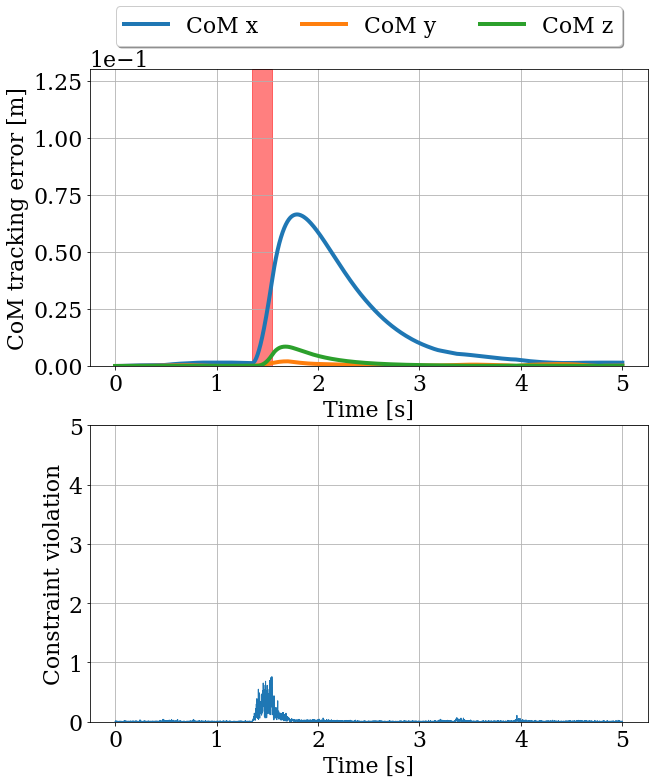

In [18]:
fig, ax = plt.subplots(2, figsize=(10, 12))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
for i in range(3):
    err = np.abs([data.com.pos[i,0]-data.com.pos_ref[i,0] for data in LOG])
    ax[0].plot(time, err, lw=4, label='CoM '+axes[i])
    
ax[0].axvspan(IMPACT_START/1000.0, (IMPACT_START+IMPACT_DURATION)/1000.0 , alpha=0.5, color='red')
ax[0].grid()
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('CoM tracking error' + ' [m]' )
_ = ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
             ncol=3, fancybox=True, shadow=True)
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[0].set_ylim([0, 0.13])

slack = [data.slack[1, 0] for data in LOG]
ax[1].plot(time, slack, lw=1)
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Constraint violation' )
# ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].set_ylim([0, 5])

file_name = 'err_'
if NS3:
    file_name += SCENARIO
if LOCAL:
    file_name += '_local'
fig.savefig(file_name + '.png', bbox_inches='tight')

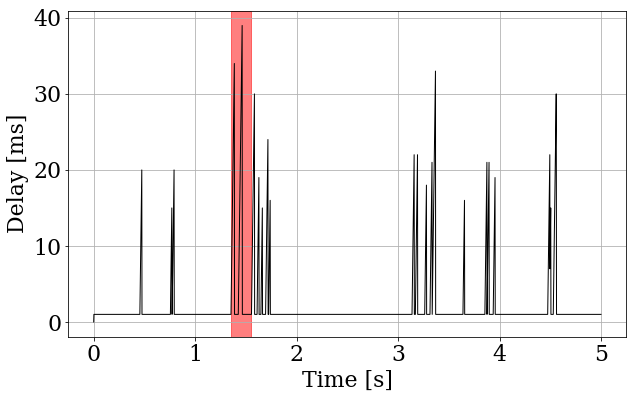

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
delays = [data.delay for data in LOG]
ax.plot(time, delays, lw=1, color='k')
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Delay [ms]' )
ax.axvspan(IMPACT_START/1000.0, (IMPACT_START+IMPACT_DURATION)/1000.0 , alpha=0.5, color='red')

In [20]:
com_err = [np.linalg.norm(data.com.pos-data.com.pos_ref) for data in LOG]
print np.mean(com_err)
print np.mean(slack)

0.01369016672908592
0.022450661423360718
